# Clustering analysis 
for algorithms with similarity matrix output



Hierarchical clustering is performed in an agglomerative manner with Ward's method as the chosen similarity definition. In the case of our SimRank and REGE implementation, similarity matrix is passed in for clustering, which is first converted to distance matrix before the clustering procedure. In the case of RoleSim implementation, dissimilarity matrix is passed in for direct clustering.

An optimal cluster number between 2 and 10 is chosen by finding the maximum average silhouette width. The width should be larger than 0.5 to indicate a reasonable clustering, given that the data considered is in a small enough dimension of 2. Otherwise, we conclude that no meaningful clustering is obtained, or that the cluster formed is too weak for further analysis.

In [3]:
libs <- c(
  "dplyr",
  "tidyr",
  "readr",
  "arrow",
  "tibble",
  "cluster",
  "ggplot2"
)
new.packages <- libs[!(libs %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)
invisible(lapply(libs, library, character.only = TRUE))


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'arrow'


The following object is masked from 'package:utils':

    timestamp




### Function to find optimal cluster (role) number

In [55]:
clustering <- function(sims, type, algo, n=0) {

  #' @param sims list of (dis)similarity matrices
  #' @param type graph names, for outputing results, for output naming purpose
  #' @param algo character of equivalence algorithm name, for output naming purpose
  #' 
  #' @return nested list of clustering results when meaningful clustering is obtained
  #'         - type (e.g. replies, votes, follows) as list name
  #'          - sim: original similarity/dissimilarity matrix
  #'          - optimk: optimal number of clusters
  #'          - rolelist: role assignment in named list form, where names are node_id and values are role assignment
  #'         - membership: a data frame combining role assignment for all types
  #'          - name: node_id
  #'          - group: combination of group assignments e.g. 1_2_1
  #'          - group_<type>: role assignment for individual type
  
  res <- list()
  n <- ifelse(n==0, ncol(sims[[1]]), n)
  for (type in types) {
    
    sim <- sims[[type]]

    # adjust for structural equivalence due to different output format from sna package
    if (algo=="structural") {
      membership <- data.frame(node_id=sim$cluster$plabels)
      dist <- as.dist(sim$dist)
      res_hc <- sim$cluster$cluster
    } else {
      membership <- data.frame(node_id=colnames(sims[[1]]))
      dist <- as.dist(if (algo == "rolesim") sim else 1 - sim)
      res_hc <- hclust(dist, method="ward.D")
    }

    k <- c(2:10)
    width_hc <- rep(NA, length(k))

    for (i in 1:length(k)){
      ass_hc = cutree(res_hc,k=k[i])
      sil <- silhouette(ass_hc,dist)
      sil
      width_hc[i] <- summary(sil)$avg.width
    }
      
    optimk <- which.max(width_hc)+1
    
    df <- data.frame(x = k, y = width_hc)
    p <- ggplot(df, aes(x = x, y = y)) +
          geom_line() +
          geom_point() +
          geom_hline(yintercept=0.5, linetype = "dashed", colour = "red")+
          labs(
            title = paste("Average silhouette width for", type),
            x = "Number of roles",
            y = "Average silhouette width") +
          theme_bw()
    
    ggsave(paste0("results/",algo,"/",algo,"-",n,"-",type,"-silhouette.png"))
    print(p)

    plot(res_hc, main=paste("Hierarchical clustering dendrogram for", type), xlab="nodes", cex=0.5)

    if (max(width_hc) > 0.4){
      rolelist <- cutree(res_hc, k = optimk)
      rect.hclust(res_hc, k=optimk, border=1:optimk, cluster=rolelist)
      print(paste0("Graph type '", type, "': Best average silhouette width at cluster number k=", optimk))
      
      if (algo=="structural") {
        assignment <- data.frame(name = sim$cluster$plabels,
                               role = rolelist)
      } else {
        assignment <- data.frame(name = names(rolelist),
                               role = unlist(rolelist))
                               }
      res[[type]] <- list(
        sim = sim,
        optimk = optimk,
        rolelist = rolelist,
        res_hc = res_hc
      )

      membership <- full_join(membership, assignment, by = 'name') %>%
                      rename_with(~ paste0("group_", type), "role")

    } else print(paste0("Graph type '", type, "': All attempts result in low average silhouette widths. No meaningful clustering result."))
    
    dev.copy(png, paste0("results/",algo,"/",algo,"-",n,"-",type,"-dendrogram.png"))
    dev.off()

  }

  if(ncol(membership)>1){
    res[["membership"]] <- membership %>% 
                    unite(group,contains('group_'), remove=FALSE) %>%
                    as.data.frame()
    
    print(head(res[["membership"]]))
    saveRDS(res, file=paste0("results/",algo,"/",algo,"-",n,"-clustering",".rds"))
  }

}


### Structural equivalence  

Saving 6.67 x 6.67 in image


[1] "Graph type 'replies': All attempts result in low average silhouette widths. No meaningful clustering result."


Saving 6.67 x 6.67 in image


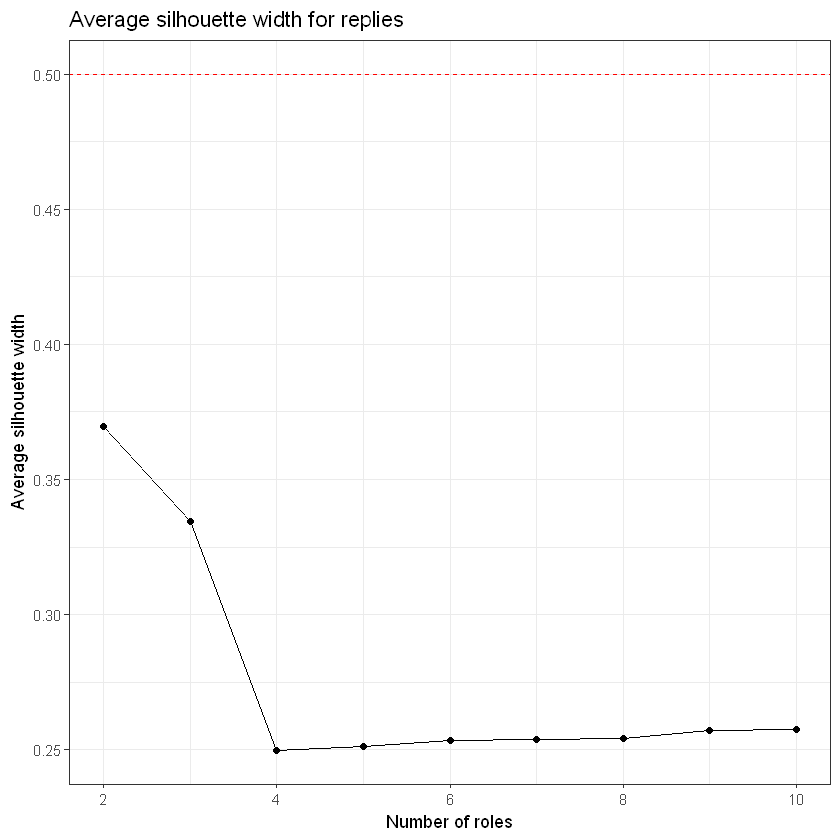

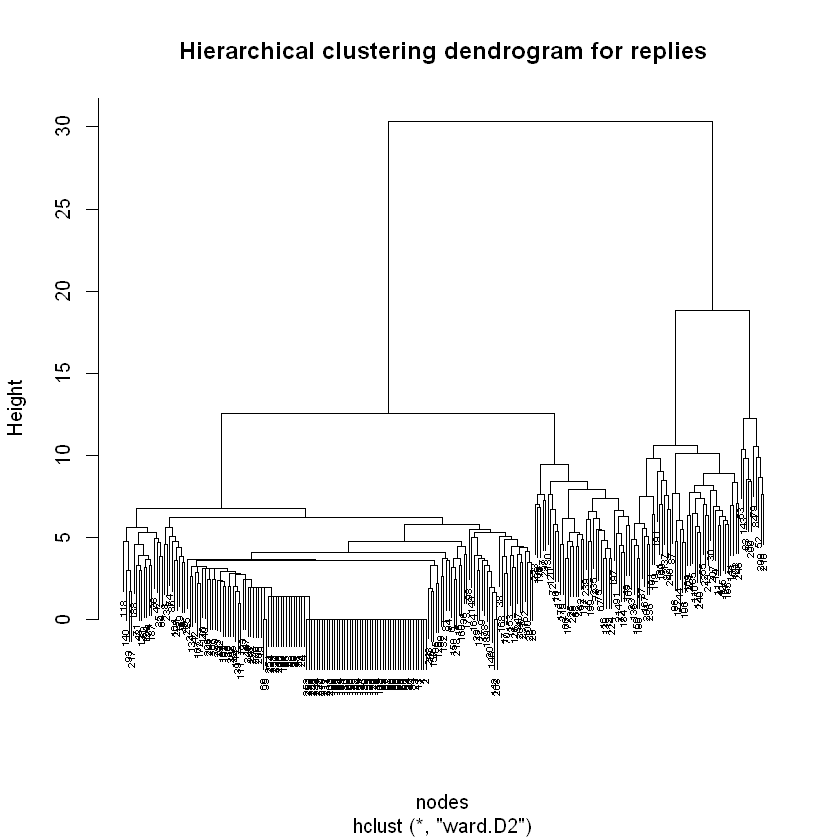

[1] "Graph type 'votes': All attempts result in low average silhouette widths. No meaningful clustering result."


Saving 6.67 x 6.67 in image


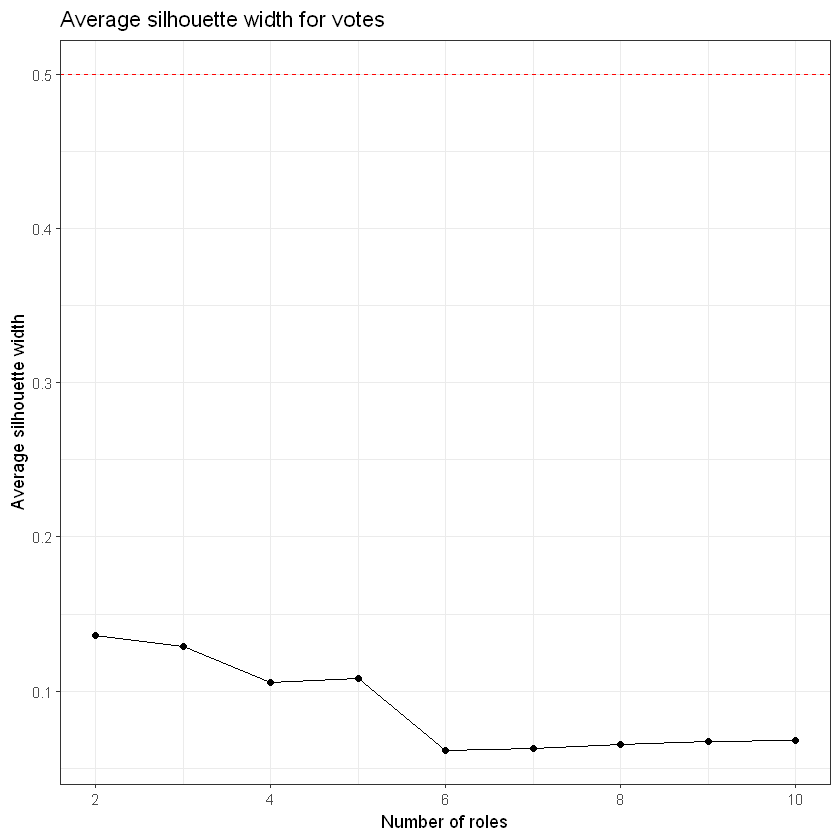

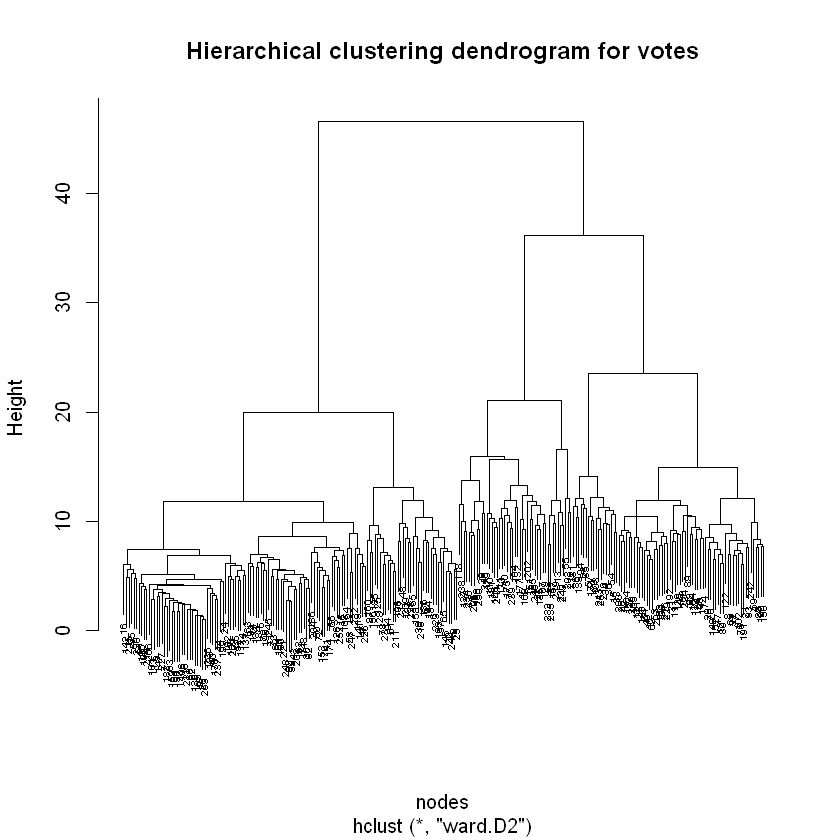

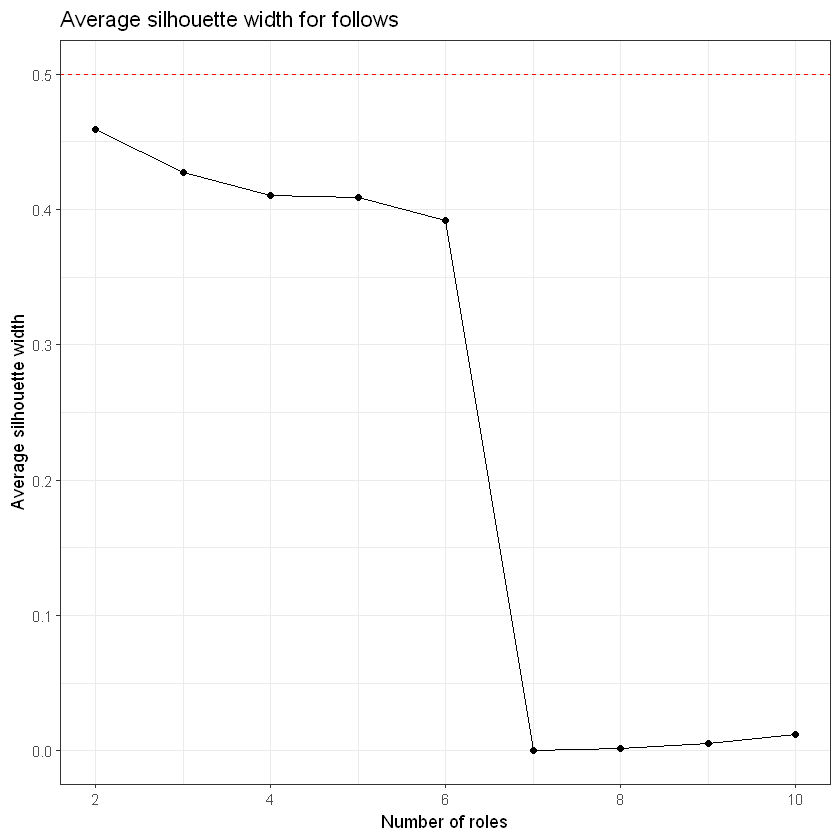

[1] "Graph type 'follows': Best average silhouette width at cluster number k=2"
  node_id group group_follows
1     625     1             1
2   14285     1             1
3   18786     1             1
4   30760     1             1
5   31518     1             1
6   35334     2             2


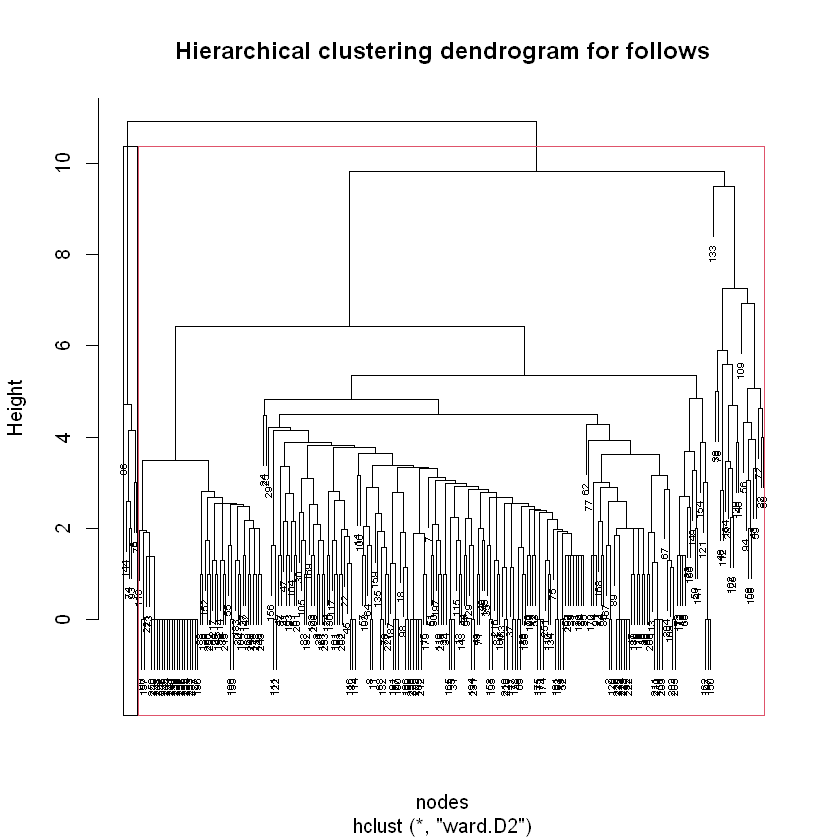

In [47]:
types <- c("replies", "votes", "follows")
sims <- list()
n_struct<- 253

for (type in types) {
  structoutput <- readRDS(paste0("results/structural/struct-",n_struct,"-",type,".rds"))
  sims[[type]] <- structoutput
}

clustering(sims, types, "structural", n_struct)	

### SimRank

The parquet files may take time to load.

Saving 6.67 x 6.67 in image


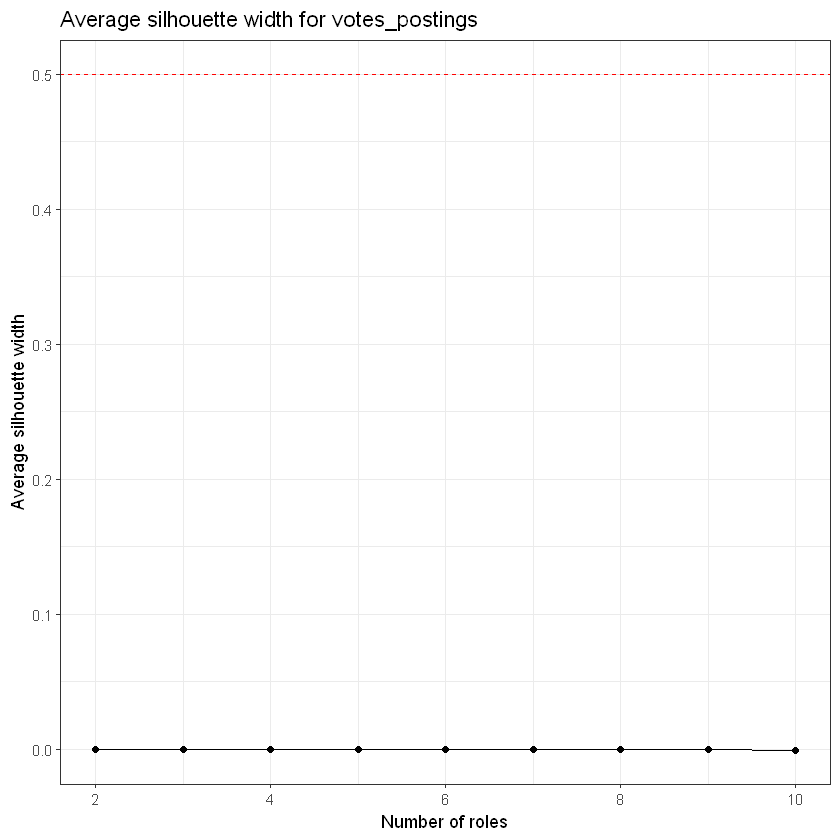

[1] "Graph type 'votes_postings': All attempts result in low average silhouette widths. No meaningful clustering result."


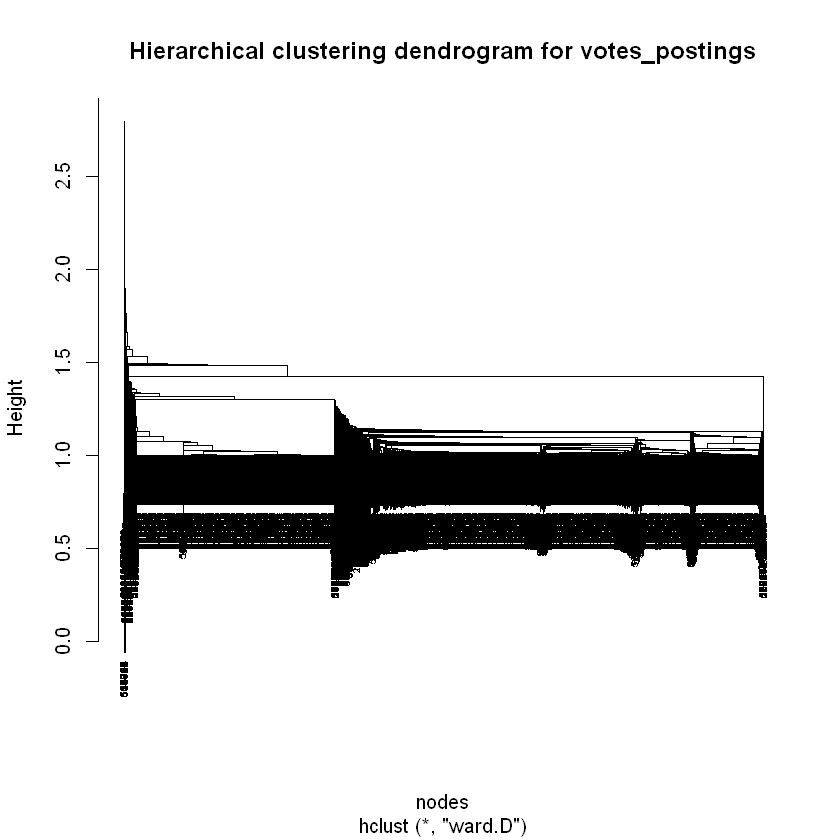

In [48]:
# types <- c("postings_replies", "votes_postings_unweighted", "votes_postings")
types <- c("votes_postings")
sims <- list()

for (type in types) {
  # sims[[type]] <- read_parquet(paste0("results/simrank/sr_",type,".parquet"))
  sims[[type]] <- read_parquet("C:/tmp/equivalence-based-network-role-mining/results/simrank/sr_votes_postings.parquet")
  sims[[type]] <- sims[[type]] %>% select(-last_col())
}

clustering(sims, types, "simrank")	

### RoleSim

Saving 6.67 x 6.67 in image


[1] "Graph type 'replies': All attempts result in low average silhouette widths. No meaningful clustering result."


Saving 6.67 x 6.67 in image


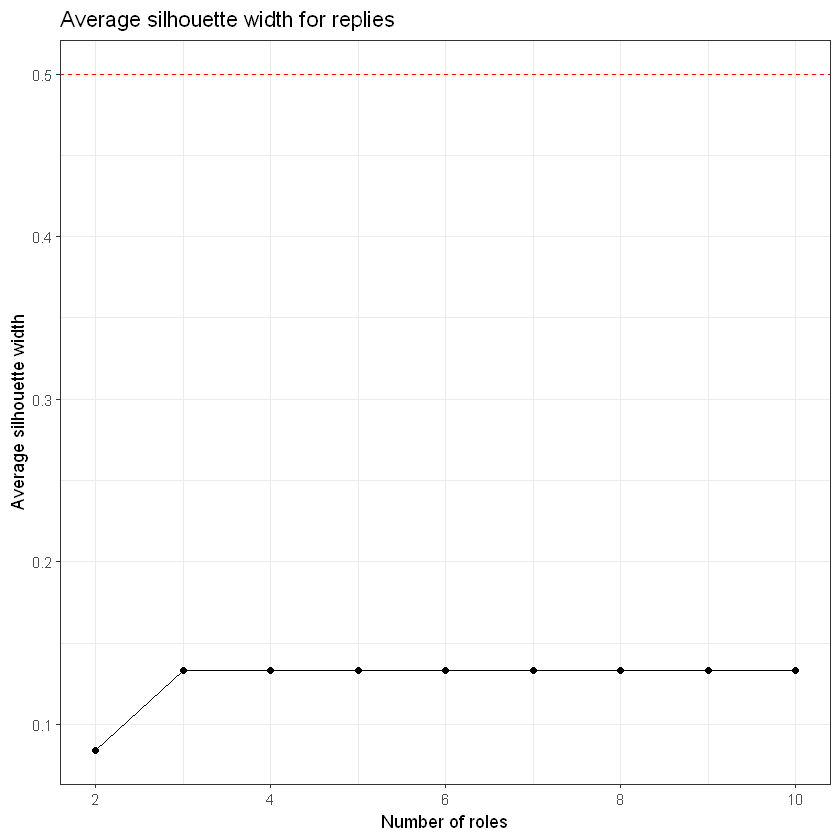

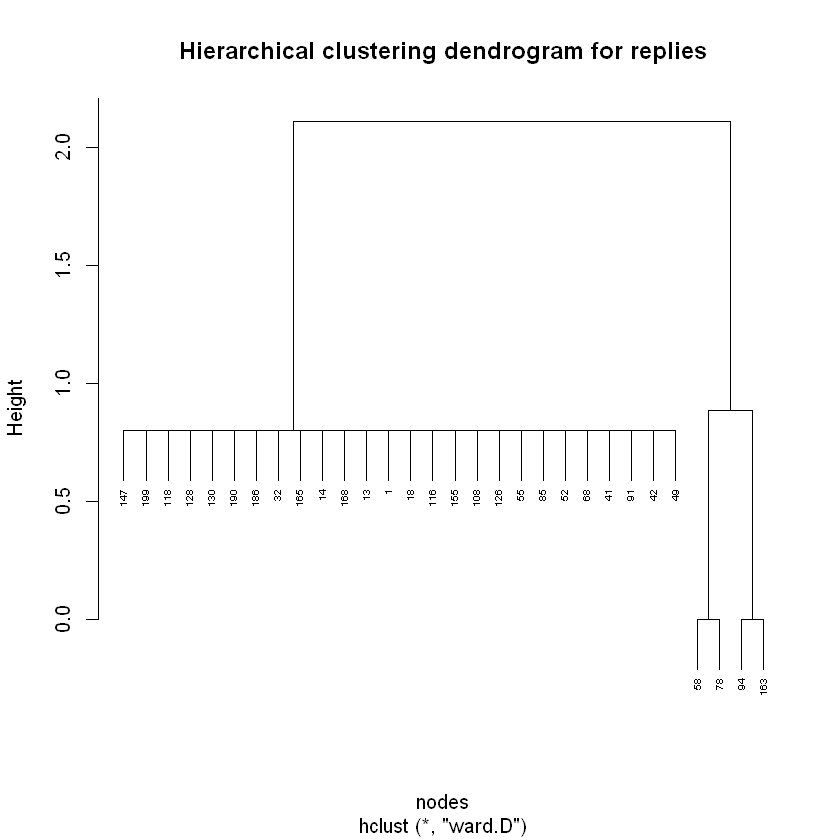

[1] "Graph type 'votes': All attempts result in low average silhouette widths. No meaningful clustering result."


Saving 6.67 x 6.67 in image


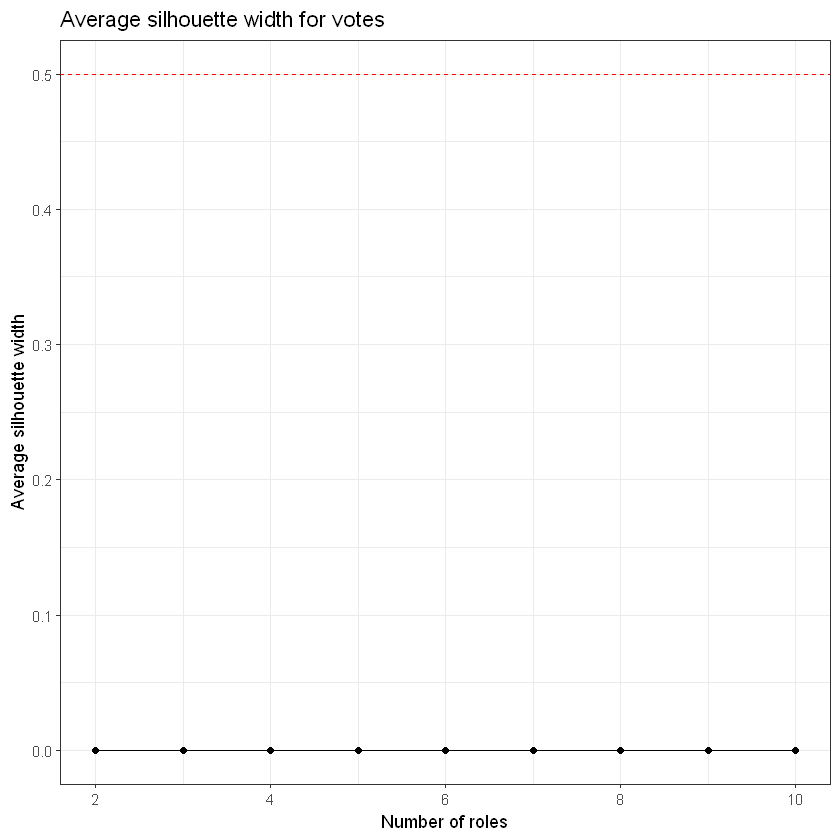

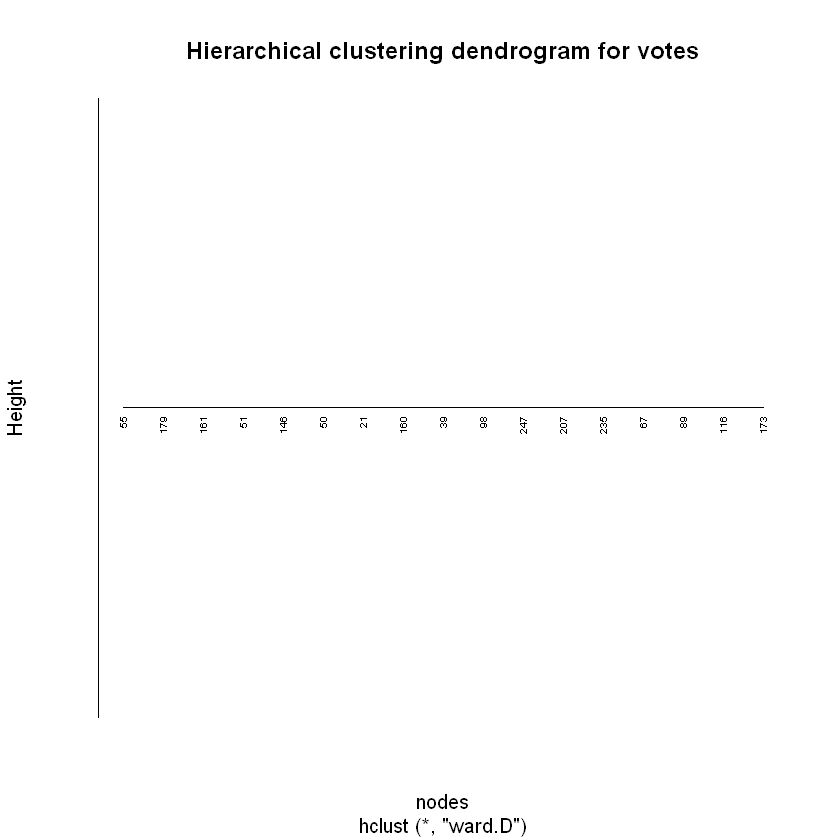

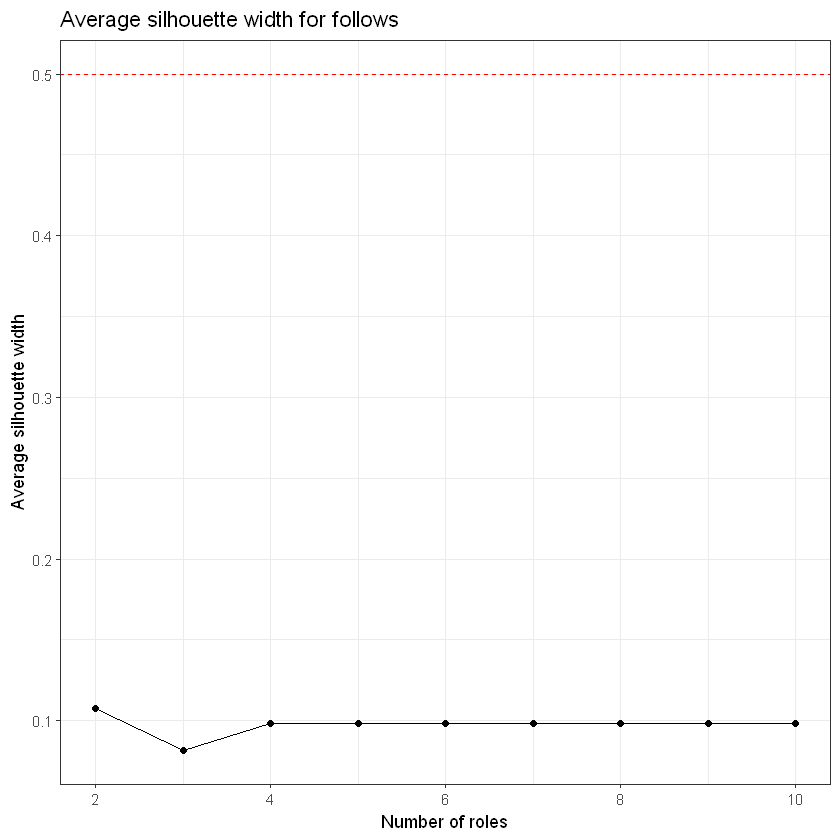

[1] "Graph type 'follows': All attempts result in low average silhouette widths. No meaningful clustering result."


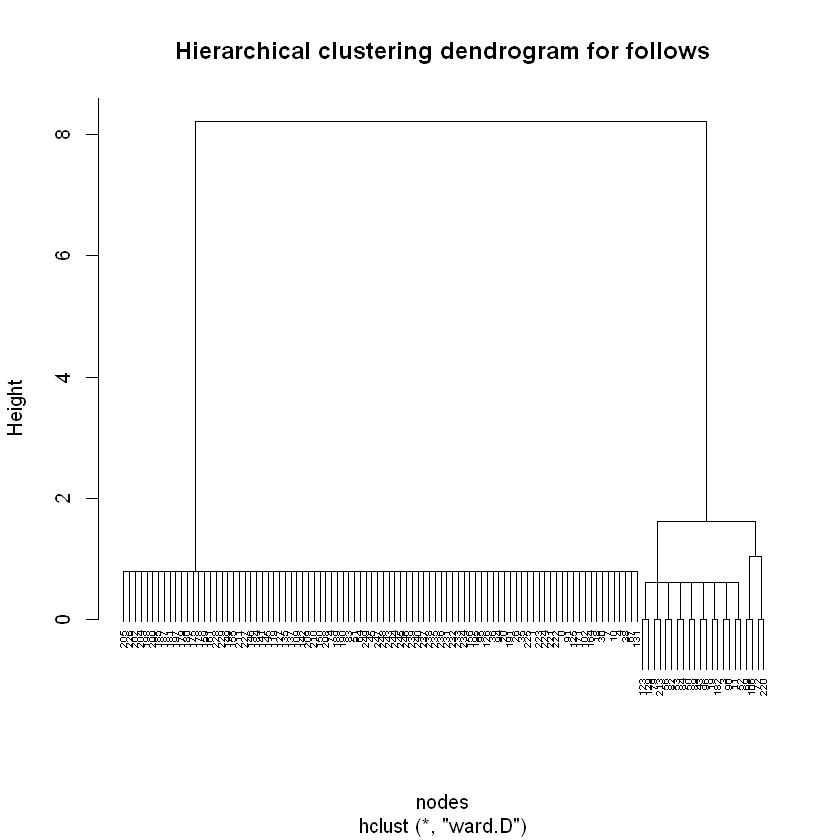

In [32]:
types <- c("replies", "votes", "follows")
# types <- c("replies")
sims <- list()
n_rolesim <- 253

for (type in types) {
  m <- read_csv(paste0("results/rolesim/",type,"-",n_rolesim,"-dissimilarity-matrix.csv"), show_col_types = FALSE, name_repair = "unique_quiet") 
  sims[[type]] <- m %>% column_to_rownames(var = colnames(m)[1])
}

clustering(sims, types, "rolesim")

### REGE

Saving 6.67 x 6.67 in image


[1] "Graph type 'replies': Best average silhouette width at cluster number k=7"


Saving 6.67 x 6.67 in image


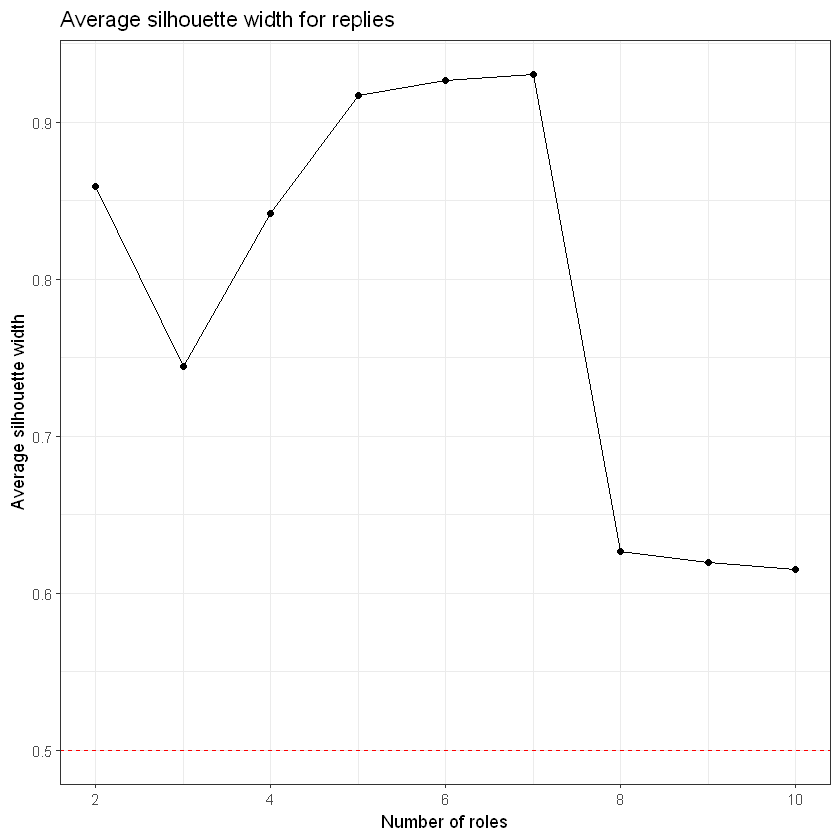

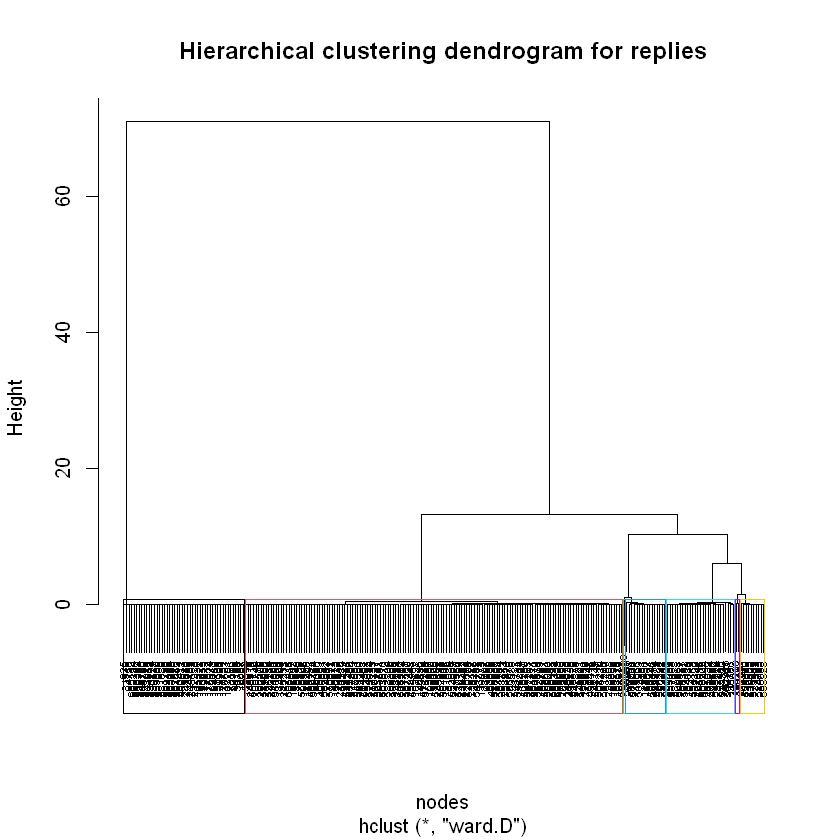

[1] "Graph type 'votes': Best average silhouette width at cluster number k=5"


Saving 6.67 x 6.67 in image


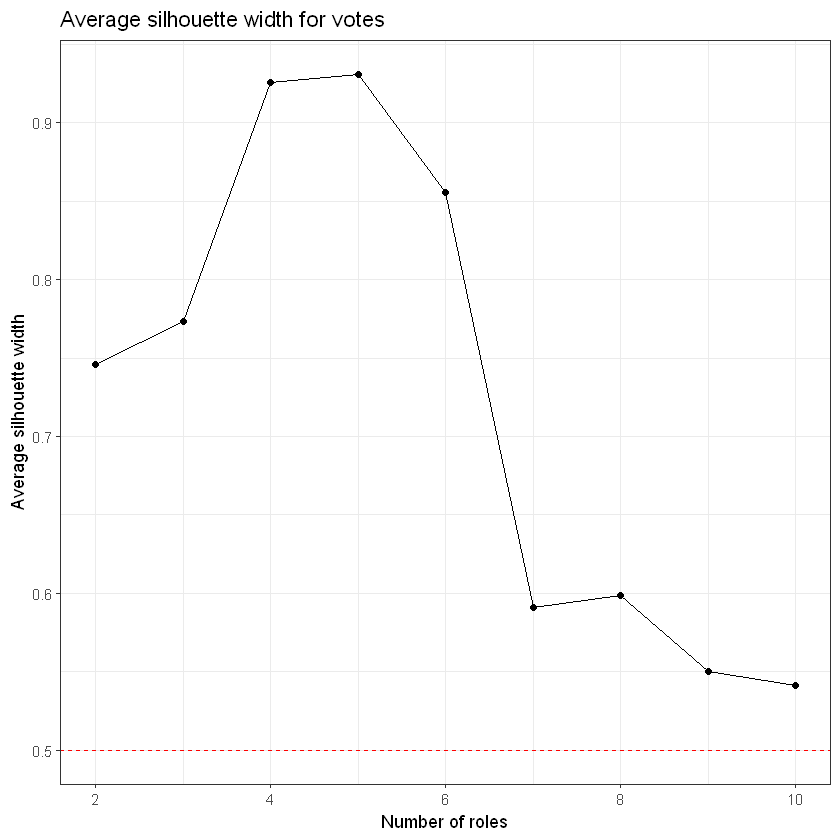

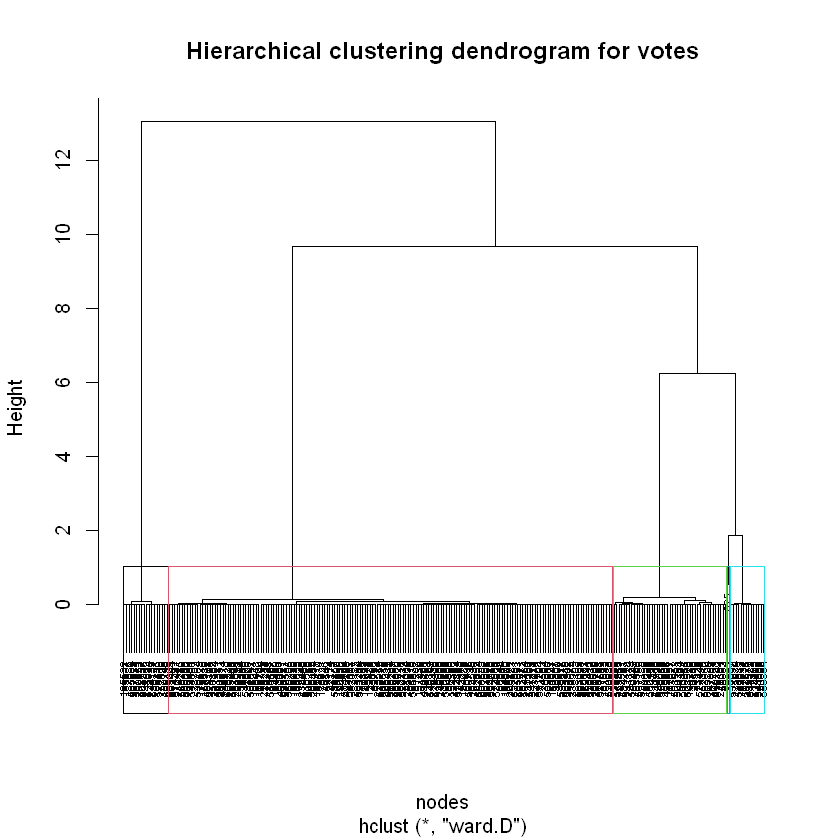

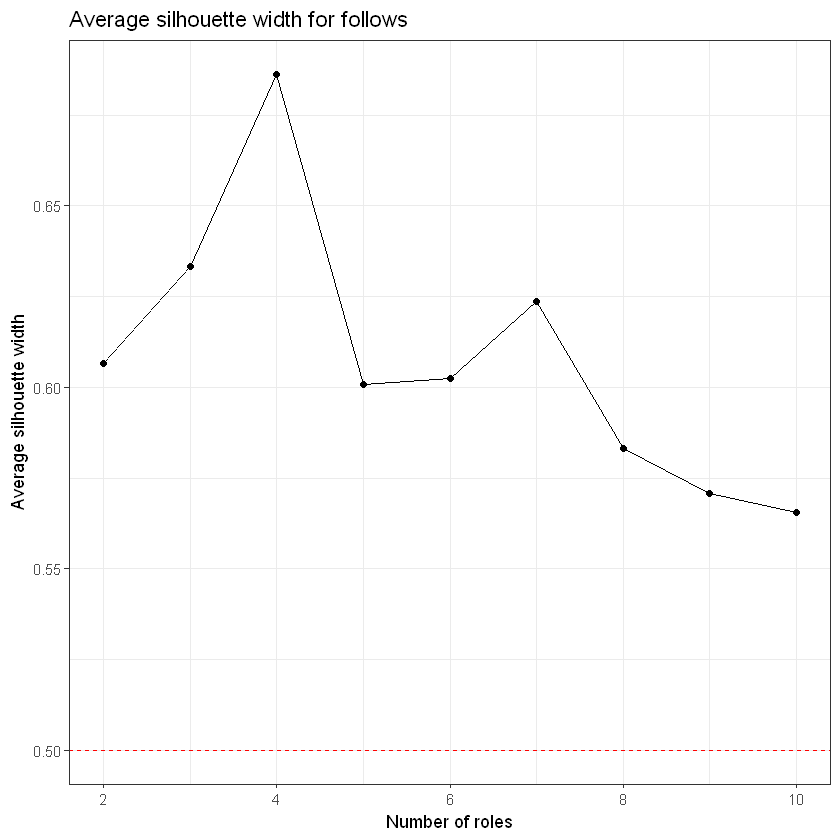

[1] "Graph type 'follows': Best average silhouette width at cluster number k=4"
  node_id group group_follows
1    6007     4             4
2   14285     1             1
3   18786     1             1
4   24561     4             4
5   26146     4             4
6   28707     4             4


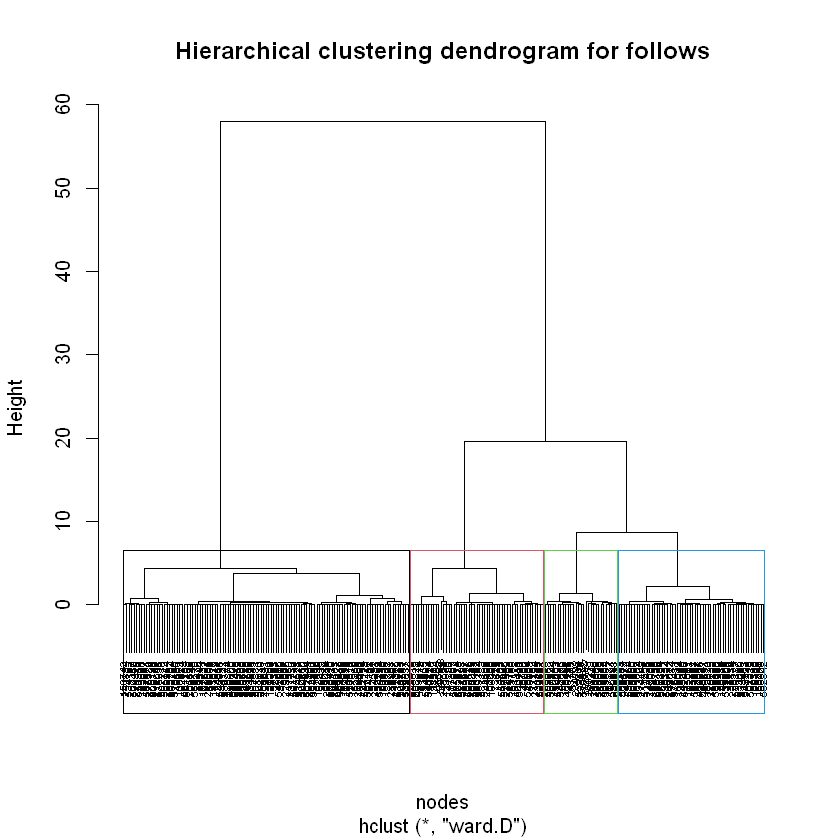

In [49]:
types <- c("replies", "votes", "follows")
sims <- list()
n_rege <- 253

for (type in types) {
  regeoutput <- readRDS(paste0("results/rege/rege-",type,"-",n_rege,".rds"))
  sims[[type]] <- regeoutput[[type]]
}

clustering(sims, types, "rege")	

#### Plot interpretation

For `replies` under a  7-role setting, 2 of the roles have a very small role size as shown in the dendrogram. If we instead adopt a role number of 5, we see that a high silhouette score can be maintained without much decrease.  Hence a more parsimonious structure of 5 roles will be adopted for better interpretability.

Similarly for `votes`, a more parsimonious structure of 4 roles will be adopted instead of 5.

No such situation happens in the `follows` case.

png 
  3

png 
  2

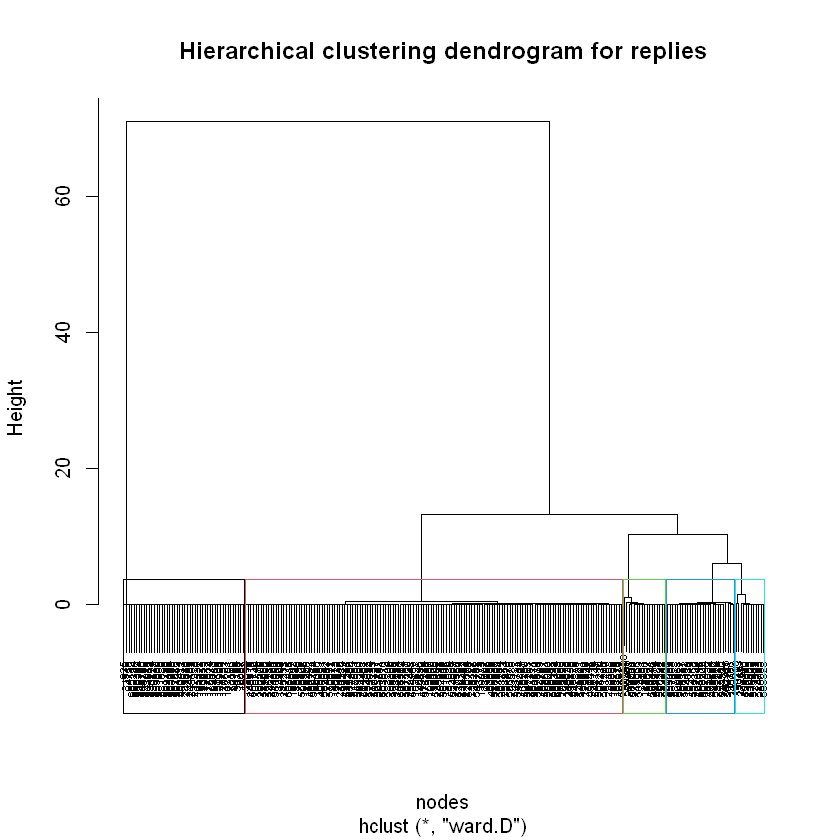

png 
  3

png 
  2

,name,group,group_replies,group_votes,group_follows
,<chr>,<chr>,<int>,<int>,<int>
1,6007,1_1_4,1,1,4
2,14285,1_2_1,1,2,1
3,18786,2_2_1,2,2,1
4,24561,3_2_4,3,2,4
5,26146,4_2_4,4,2,4
6,28707,4_2_4,4,2,4


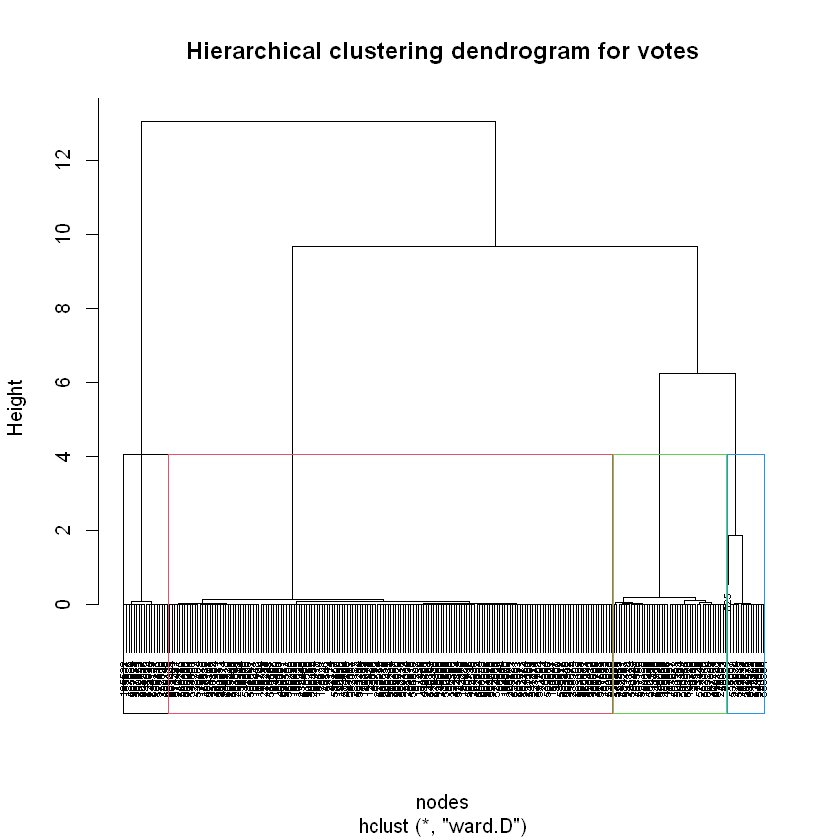

In [56]:
regeclu <- readRDS("results/rege/rege-253-clustering.rds")

# replies
replies <- regeclu$replies
replies$optimk <- 5
replies$rolelist <- cutree(replies$res_hc, k = 5)


plot(replies$res_hc, main="Hierarchical clustering dendrogram for replies", xlab="nodes", cex=0.5)
rect.hclust(replies$res_hc, k=5, border=1:5, cluster=replies$rolelist)
dev.copy(png, "results/rege/rege-253-replies-dendrogram-update.png")
dev.off()

# votes
votes <- regeclu$votes
votes$optimk <- 4
votes$rolelist <- cutree(votes$res_hc, k = 4)

plot(votes$res_hc, main="Hierarchical clustering dendrogram for votes", xlab="nodes", cex=0.5)
rect.hclust(votes$res_hc, k=4, border=1:4, cluster=votes$rolelist)

dev.copy(png, "results/rege/rege-253-votes-dendrogram-update.png")
dev.off()

membership <- as.data.frame(replies$rolelist) %>% 
  rownames_to_column("name") %>%
  full_join(as.data.frame(votes$rolelist) %>% rownames_to_column("name"), by = "name") %>%
  full_join(as.data.frame(regeclu$follows$rolelist) %>% rownames_to_column("name"), by = "name") %>%
  rename(group_replies = "replies$rolelist", group_votes ="votes$rolelist", group_follows = "regeclu$follows$rolelist") %>%
  unite(group,contains('group_'), remove=FALSE) %>%
  as.data.frame()

head(membership)

# update object
regeclu_update <- regeclu
regeclu_update$replies <- replies
regeclu_update$votes <- votes
regeclu_update$membership <- membership

saveRDS(regeclu_update, file="results/rege/rege-253-clustering-update.rds")